In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pandas.plotting import lag_plot
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt, ExponentialSmoothing
import statsmodels.graphics.tsaplots as tsa_plots
import statsmodels.tsa.statespace as tm_models
from datetime import datetime,time
import warnings
import itertools
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')

from pylab import rcParams
from statsmodels.tsa.arima_model import ARIMA

from sklearn.metrics import mean_squared_error
import statsmodels.formula.api as smf

In [2]:
from google.colab import files
Uploaded=files.upload()

Saving CocaCola_Sales_Rawdata.xlsx to CocaCola_Sales_Rawdata.xlsx


In [7]:
data=pd.read_excel('CocaCola_Sales_Rawdata.xlsx')

In [8]:
data

,Quarter,Sales
0,Q1_86,1734.827000
1,Q2_86,2244.960999
2,Q3_86,2533.804993
3,Q4_86,2154.962997
4,Q1_87,1547.818996
5,Q2_87,2104.411995
6,Q3_87,2014.362999
7,Q4_87,1991.746998
8,Q1_88,1869.049999
9,Q2_88,2313.631996


# **Visualization and Data Preprocessing**

In [9]:
data.head()

,Quarter,Sales
0,Q1_86,1734.827000
1,Q2_86,2244.960999
2,Q3_86,2533.804993
3,Q4_86,2154.962997
4,Q1_87,1547.818996


In [10]:
data.tail()

,Quarter,Sales
37,Q2_95,4936.0
38,Q3_95,4895.0
39,Q4_95,4333.0
40,Q1_96,4194.0
41,Q2_96,5253.0


In [11]:
data.info() #42 rows, 2 columns and no null values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42 entries, 0 to 41
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Quarter  42 non-null     object 
 1   Sales    42 non-null     float64
dtypes: float64(1), object(1)
memory usage: 800.0+ bytes


In [12]:
data[data.duplicated()] #no duplicate values

,Quarter,Sales


In [15]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Sales,42.0,2994.353308,977.930896,1547.818996,2159.714247,2782.376999,3609.25,5253.0


In [22]:
# We will extract Quarter values and Year values separately from 'Quarter column'
data['Quarters'] = 0
data['Year'] = 0
for i in range(42):
    p = data["Quarter"][i]
    data['Quarters'][i]= p[0:2]
    data['Year'][i]= p[3:5]

In [23]:
data.head()

,Quarter,Sales,Quarters,Year
0,Q1_86,1734.827000,Q1,86
1,Q2_86,2244.960999,Q2,86
2,Q3_86,2533.804993,Q3,86
3,Q4_86,2154.962997,Q4,86
4,Q1_87,1547.818996,Q1,87


In [24]:
# Getting dummy variables for Quarters Q1, Q2, Q3, Q4
Quarters_Dummies = pd.DataFrame(pd.get_dummies(data['Quarters']))
data = pd.concat([data,Quarters_Dummies],axis = 1)
data.head()

,Quarter,Sales,Quarters,Year,Q1,Q2,Q3,Q4
0,Q1_86,1734.827000,Q1,86,1,0,0,0
1,Q2_86,2244.960999,Q2,86,0,1,0,0
2,Q3_86,2533.804993,Q3,86,0,0,1,0
3,Q4_86,2154.962997,Q4,86,0,0,0,1
4,Q1_87,1547.818996,Q1,87,1,0,0,0


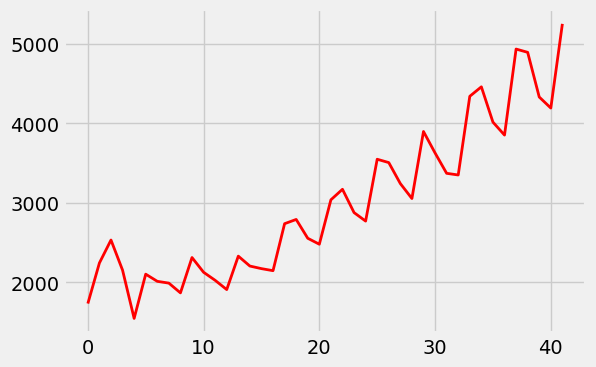

In [28]:
# Lineplot for Sales of CocaCola
plt.figure(figsize=(6,4))
plt.plot(data['Sales'], color = 'red', linewidth=2)

<Axes: >

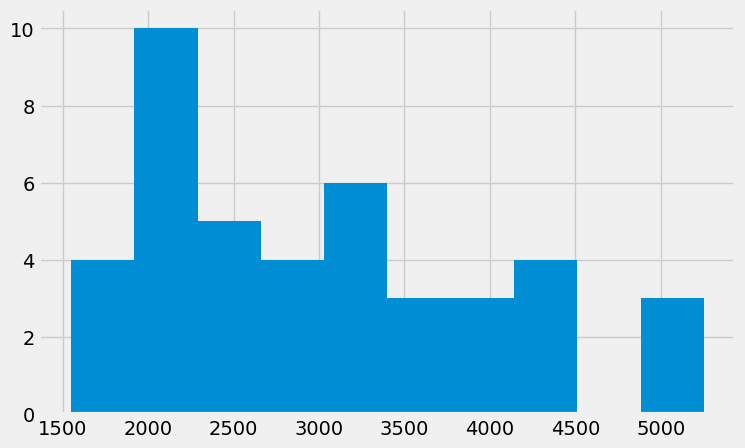

In [29]:
# Histogram
data['Sales'].hist(figsize=(8,5))

<Axes: ylabel='Density'>

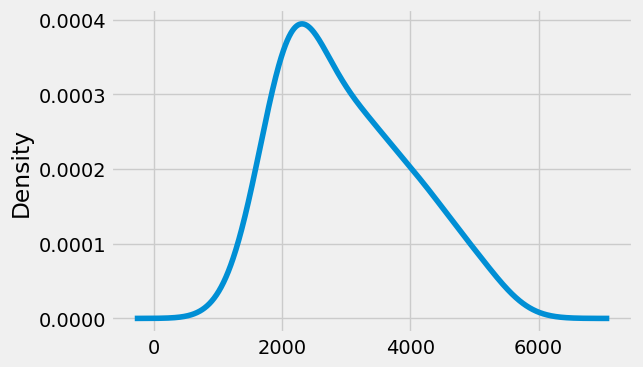

In [31]:
# Density Plot
data['Sales'].plot(kind = 'kde', figsize=(6,4))

<Axes: xlabel='Quarters', ylabel='Sales'>

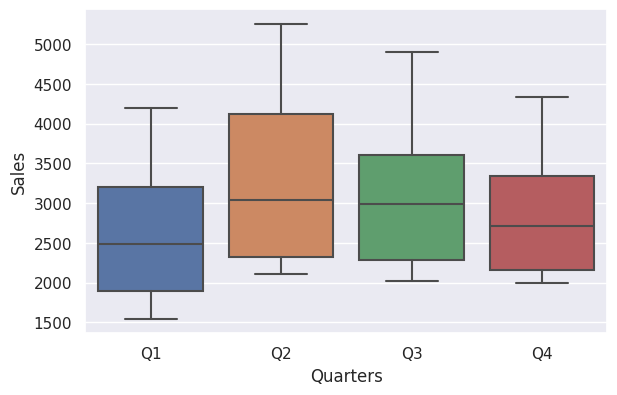

In [33]:
#boxplot of Quarters Vs. Sales
sns.set(rc={'figure.figsize':(6,4)})
sns.boxplot(x="Quarters",y="Sales",data=data)

<Axes: xlabel='Year', ylabel='Sales'>

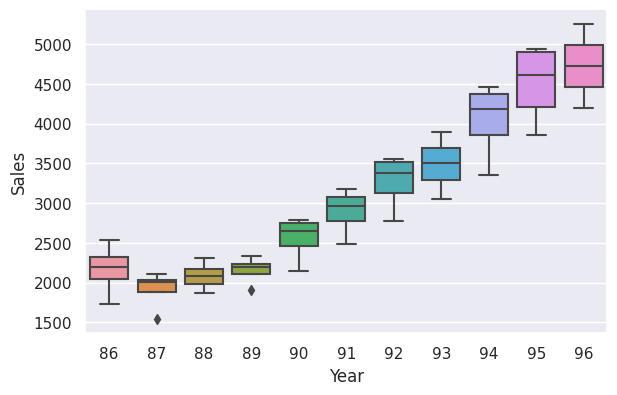

In [34]:
# boxplot of Years Vs. Sales
sns.boxplot(x="Year",y="Sales",data=data)

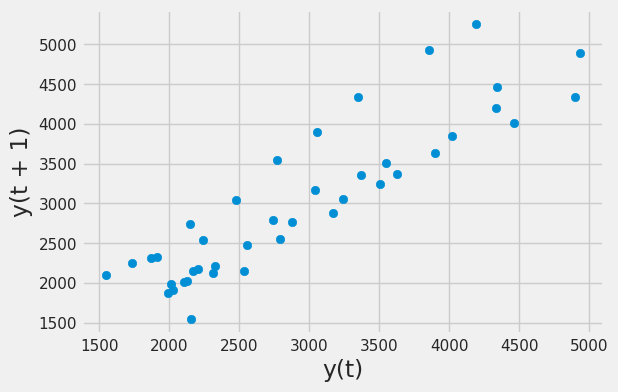

In [36]:
lag_plot(data['Sales'])
plt.show()

<Axes: xlabel='Year', ylabel='Sales'>

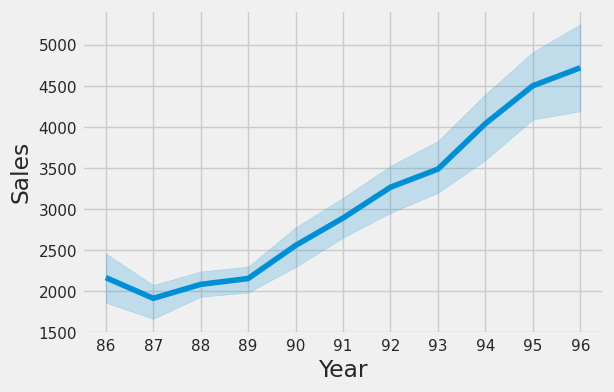

In [38]:
plt.figure(figsize=(6,4))
sns.lineplot(x="Year",y="Sales",data=data)

<Axes: xlabel='Quarters', ylabel='Year'>

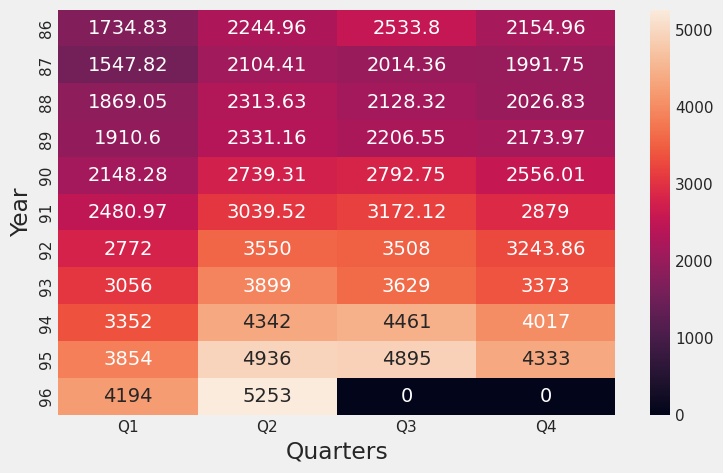

In [40]:
plt.figure(figsize=(8, 5))
heatmap_y_month = pd.pivot_table(data=data,values="Sales",index="Year",columns="Quarters",aggfunc="mean",fill_value=0)
sns.heatmap(heatmap_y_month,annot=True,fmt="g")

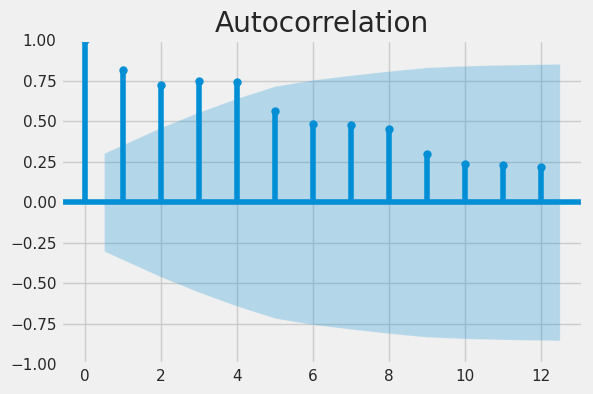

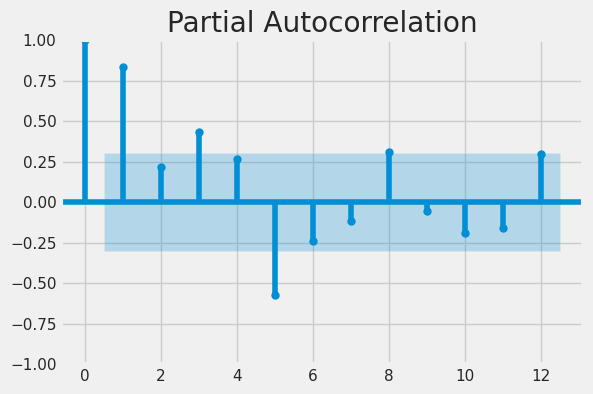

In [41]:
tsa_plots.plot_acf(data.Sales,lags=12)
tsa_plots.plot_pacf(data.Sales,lags=12)
plt.show()

# **Data Driven Forecasting Methods**

**Splitting Data**

In [45]:
# Splitting data into Train and Test (77/33)
Train = data.head(32)
Test = data.tail(10)

**Moving Average Method**

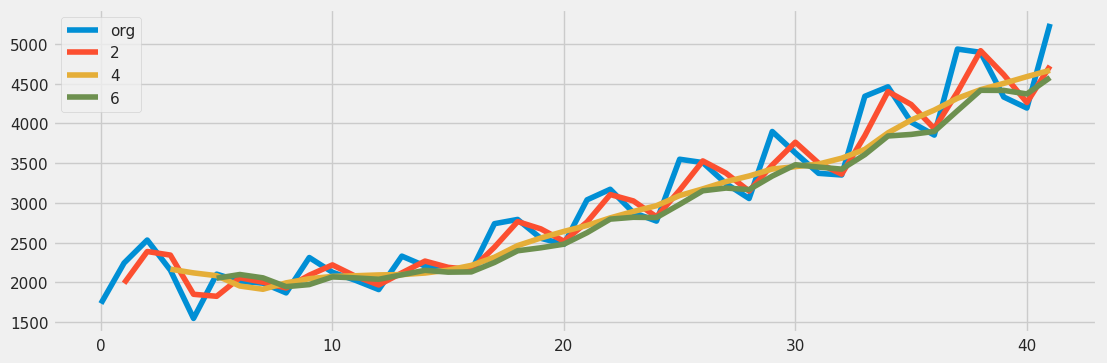

In [46]:
plt.figure(figsize=(12,4))
data.Sales.plot(label="org")
for i in range(2,8,2):
    data["Sales"].rolling(i).mean().plot(label=str(i))
plt.legend(loc='best')

**Time series decomposition plot**

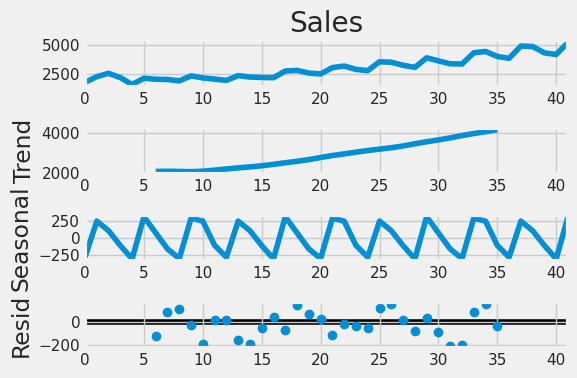

In [48]:
decompose_ts_add = seasonal_decompose(data.Sales,period=12)
decompose_ts_add.plot()
plt.show()

**Evaluation Metric RMSE**

In [49]:
def RMSE(org, pred):
    rmse=np.sqrt(np.mean((np.array(org)-np.array(pred))**2))
    return rmse

**Simple Exponential Method**

In [50]:
ses_model = SimpleExpSmoothing(Train["Sales"]).fit()
pred_ses = ses_model.predict(start = Test.index[0],end = Test.index[-1])
rmse_ses_model = RMSE(Test.Sales, pred_ses)
rmse_ses_model

1034.9359056453961

**Holt method**

In [51]:
hw_model = Holt(Train["Sales"]).fit()
pred_hw = hw_model.predict(start = Test.index[0],end = Test.index[-1])
rmse_hw_model = RMSE(Test.Sales, pred_hw)
rmse_hw_model

941.6367810616845

**Holts winter exponential smoothing with additive seasonality and additive trend**

In [52]:
hwe_model_add_add = ExponentialSmoothing(Train["Sales"],seasonal="add",trend="add",seasonal_periods=4).fit()
pred_hwe_add_add = hwe_model_add_add.predict(start = Test.index[0],end = Test.index[-1])
rmse_hwe_add_add_model = RMSE(Test.Sales, pred_hwe_add_add)
rmse_hwe_add_add_model

633.4394050169811

**Holts winter exponential smoothing with multiplicative seasonality and additive trend**

In [53]:
hwe_model_mul_add = ExponentialSmoothing(Train["Sales"],seasonal="mul",trend="add",seasonal_periods=4).fit()
pred_hwe_mul_add = hwe_model_mul_add.predict(start = Test.index[0],end = Test.index[-1])
rmse_hwe_model_mul_add_model = RMSE(Test.Sales, pred_hwe_mul_add)
rmse_hwe_model_mul_add_model

568.1679856842486

# **Model based Forecasting Methods**

In [54]:
# Data preprocessing for models
data["t"] = np.arange(1,43)
data["t_squared"] = data["t"]*data["t"]

data["log_sales"] = np.log(data["Sales"])

data.head()

,Quarter,Sales,Quarters,Year,Q1,Q2,Q3,Q4,t,t_squared,log_sales
0,Q1_86,1734.827000,Q1,86,1,0,0,0,1,1,7.458663
1,Q2_86,2244.960999,Q2,86,0,1,0,0,2,4,7.716443
2,Q3_86,2533.804993,Q3,86,0,0,1,0,3,9,7.837477
3,Q4_86,2154.962997,Q4,86,0,0,0,1,4,16,7.675529
4,Q1_87,1547.818996,Q1,87,1,0,0,0,5,25,7.344602


In [56]:
# Splitting data into Train and Test (77/33)
Train = data.head(32)
Test = data.tail(10)

In [57]:
Train.head()

,Quarter,Sales,Quarters,Year,Q1,Q2,Q3,Q4,t,t_squared,log_sales
0,Q1_86,1734.827000,Q1,86,1,0,0,0,1,1,7.458663
1,Q2_86,2244.960999,Q2,86,0,1,0,0,2,4,7.716443
2,Q3_86,2533.804993,Q3,86,0,0,1,0,3,9,7.837477
3,Q4_86,2154.962997,Q4,86,0,0,0,1,4,16,7.675529
4,Q1_87,1547.818996,Q1,87,1,0,0,0,5,25,7.344602


**Linear Model**


In [58]:
linear_model = smf.ols('Sales~t',data=Train).fit()
pred_linear =  pd.Series(linear_model.predict(pd.DataFrame(Test['t'])))
rmse_linear_model = RMSE(Test['Sales'], pred_linear)
rmse_linear_model

752.9233932767116

**Exponential Model**

In [59]:
Exp = smf.ols('log_sales~t',data=Train).fit()
pred_Exp = pd.Series(Exp.predict(pd.DataFrame(Test['t'])))
rmse_Exp_model = RMSE(Test['Sales'], np.exp(pred_Exp))
rmse_Exp_model

590.3316432076487

**Quadratic Model**

In [60]:
Quad = smf.ols('Sales~t+t_squared',data=Train).fit()
pred_Quad = pd.Series(Quad.predict(Test[["t","t_squared"]]))
rmse_Quad_model = RMSE(Test['Sales'], pred_Quad)
rmse_Quad_model

457.735735540752

**Additive Seasonality model**

In [61]:
add_sea = smf.ols('Sales~Q1+Q2+Q3',data=Train).fit()
pred_add_sea = pd.Series(add_sea.predict(Test[['Q1', 'Q2', 'Q3']]))
rmse_add_sea = RMSE(Test['Sales'], pred_add_sea)
rmse_add_sea

1850.466546185836

**Additive Seasonality Quadratic model**

In [62]:
add_sea_Quad = smf.ols('Sales~t+t_squared+Q1+Q2+Q3',data=Train).fit()
pred_add_sea_quad = pd.Series(add_sea_Quad.predict(Test[['Q1','Q2','Q3','t','t_squared']]))
rmse_add_sea_Quad_model = RMSE(Test['Sales'], pred_add_sea_quad)
rmse_add_sea_Quad_model

277.3510771128639

**Multiplicative Seasonality model**

In [63]:
Mul_sea = smf.ols('log_sales~Q1+Q2+Q3',data=Train).fit()
pred_Mult_sea = pd.Series(Mul_sea.predict(Test))
rmse_Mul_sea = RMSE(Test['Sales'], np.exp(pred_Mult_sea))
rmse_Mul_sea

1908.2503948361164

**Multiplicative Additive Seasonality model**

In [64]:
Mul_Add_sea = smf.ols('log_sales~t+Q1+Q2+Q3',data = Train).fit()
pred_Mult_add_sea = pd.Series(Mul_Add_sea.predict(Test))
rmse_Mul_Add_sea = RMSE(Test['Sales'], np.exp(pred_Mult_add_sea))
rmse_Mul_Add_sea

448.86781826918514

In [65]:
list = [['Simple Exponential Method',rmse_ses_model], ['Holt method',rmse_hw_model],
          ['HW exp smoothing add',rmse_hwe_add_add_model],['HW exp smoothing mult',rmse_hwe_model_mul_add_model],
          ['Linear Mode',rmse_linear_model],['Exp model',rmse_Exp_model],['Quad model',rmse_Quad_model],
          ['add seasonality',rmse_add_sea],['Quad add seasonality',rmse_add_sea_Quad_model],
          ['Mult Seasonality',rmse_Mul_sea],['Mult add seasonality',rmse_Mul_Add_sea]]

In [66]:
df = pd.DataFrame(list, columns =['Model', 'RMSE_Value'])
df

,Model,RMSE_Value
0,Simple Exponential Method,1034.935906
1,Holt method,941.636781
2,HW exp smoothing add,633.439405
3,HW exp smoothing mult,568.167986
4,Linear Mode,752.923393
5,Exp model,590.331643
6,Quad model,457.735736
7,add seasonality,1850.466546
8,Quad add seasonality,277.351077
9,Mult Seasonality,1908.250395


# **Building final model with least RMSE value**

In [67]:
final_model = smf.ols('Sales~t+t_squared+Q1+Q2+Q3',data=data).fit()
pred_final = pd.Series(final_model.predict(data[['Q1','Q2','Q3','t','t_squared']]))
rmse_final_model = RMSE(data['Sales'], pred_final)
rmse_final_model

159.0552257652248

In [68]:
pred_df = pd.DataFrame({'Actual' : data.Sales, 'Predicted' : pred_final})
pred_df

,Actual,Predicted
0,1734.827000,1626.592727
1,2244.960999,2268.402339
2,2533.804993,2189.685821
3,2154.962997,1867.242917
4,1547.818996,1658.311143
5,2104.411995,2314.185178
6,2014.362999,2249.533083
7,1991.746998,1941.154603
8,1869.049999,1746.287252
9,2313.631996,2416.225709


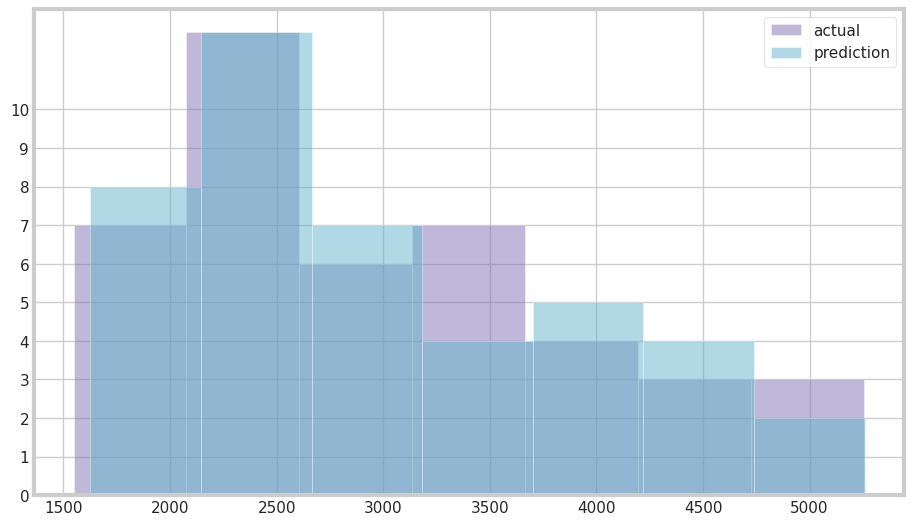

In [69]:
# Actual Vs Predicted graph

sns.set_style('whitegrid')

plt.rcParams['figure.figsize'] = (10, 6)
_, ax = plt.subplots()
ax.hist(data.Sales, color = 'm', alpha = 0.5, label = 'actual', bins=7)
ax.hist(pred_final, color = 'c', alpha = 0.5, label = 'prediction', bins=7)
ax.yaxis.set_ticks(np.arange(0,11))
ax.legend(loc = 'best')
plt.show()

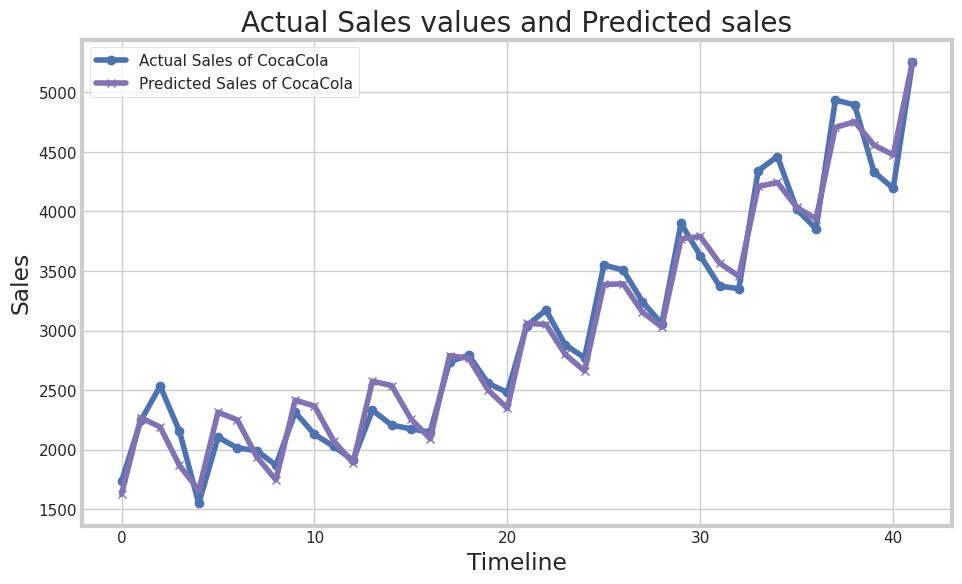

In [70]:
# Plot of Actual Sales values and Predicted sales values
plt.plot(data.Sales, color='b',marker='o', label='Actual Sales of CocaCola')
plt.plot(pred_final, color='m',marker='x', label='Predicted Sales of CocaCola')

# Added titles and adjust dimensions
plt.title('Actual Sales values and Predicted sales')
plt.xlabel("Timeline")
plt.ylabel("Sales")
plt.legend()
plt.rcParams['figure.figsize'] = (10,8)

plt.show()